# Deep-learning-based identification of protein nanobarcodes

This notebook contains the code necessary for using our trained deep neural network to reconstruct the z-stack confocal images into a 3D tomogram with nanobarcodes highlighted in false color.

Current setup in the code loads hyperparameters and network weights from the ```../network_params``` folder. These files will be downloaded from an ftp server the first time the notebook is run. Similarly, a z-stack example image will be downloaded into the ```../examples``` folder.

This notebook depends on the included Python package ```deep_nanobarcode```. For instruction on how to set up the library, see the ```README.md``` file or visit the github page at https://github.com/noegroup/deep_nanobarcode.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile, torch, os, glob, json, urllib

In [2]:
from deep_nanobarcode import dataset_handler
from deep_nanobarcode import image_processing
from deep_nanobarcode import model
import torch

GPU is available! :)
CUDA device name: NVIDIA GeForce RTX 3090
CUDA version: 11.7
PyTorch version: 2.0.1+cu117


## Initialization of deep network

- setting paths and downloading necessary files
- loading datasets
- setting up the network
- loading network weights
- downloading example image

In [3]:
series_number = 15

network_params_folder = "../network_params"
training_data_folder = "../training_data"
example_folder = "../examples"

dataset_expression_time = "24h"
dataset_scaling = "whitened"
dataset_gain = "550"

ext_str = f"{dataset_expression_time}_{dataset_scaling}_gain_{dataset_gain}"

saved_net_filename = f"weights_series_{series_number}_trained_on_{ext_str}.pth"
dataset_filename = f"kpca_input_{ext_str}.pkl"
tomo_example_filename = f"ALL_ALL_CS1_P3_CH11_z13_500nm.lsm"

for _data_folder, _data_filename in zip([network_params_folder, training_data_folder, example_folder],
                                        [saved_net_filename, dataset_filename, tomo_example_filename]):
    
    if not glob.glob(f"{_data_folder}/{_data_filename}"):

        print(f"Downloading {_data_filename}...")

        urllib.request.urlretrieve(f"https://ftp.mi.fu-berlin.de/pub/cmb-data/deep_nanobarcode/{_data_filename}",
                           f"{_data_folder}/{_data_filename}")
    else:
        
        print(f"{_data_filename} is already present!")
        
dataset = dataset_handler.NanobarcodeDataset(
brightness_data_file_name=f"{training_data_folder}/{dataset_filename}")

weights_series_15_trained_on_24h_whitened_gain_550.pth is already present!
kpca_input_24h_whitened_gain_550.pkl is already present!
loading data from ../training_data/kpca_input_24h_whitened_gain_550.pkl...
protein names = ['ENDO', 'GFP', 'GalNact', 'KDEL', 'LifeAct', 'NLS', 'SNAP25', 'STX4', 'STX6', 'TOM70', 'Vti1a', 'Blank']
Number of datapoints in train dataset = torch.Size([168232])
Number of datapoints in val dataset = torch.Size([20885])
Number of datapoints in test dataset = torch.Size([20883])
Mean value of the input data = tensor([ 3.7452, -0.2084, -0.6938,  0.5666, -0.0939, -0.7025,  0.5410,  0.7732,
         0.7225,  1.3022], device='cuda:0')
Standard deviation of the input data = tensor([5.7261, 0.9834, 0.4355, 0.2873, 1.7136, 0.4426, 0.2577, 3.7417, 0.6008,
        1.8599], device='cuda:0')
Example of augmented data =         (tensor([ 4.0762,  0.0871, -0.6074,  0.2851, -0.4812, -0.6334,  0.2224, -0.6571,
         0.3869,  0.4610], device='cuda:0'), tensor(0, device='cuda:

### Perparing the deep network and loading the weights:

In [4]:
with open(f"{network_params_folder}/model_config_series_{series_number}.json", 'r') as fp:
    network_parameters = json.load(fp)

net, train_loader, val_loader, test_loader, optimizer = model.model_factory(
    dataset, *model.separate_args(network_parameters))

net.load_state_dict(torch.load(f"{network_params_folder}/{saved_net_filename}"))

<All keys matched successfully>

### Testing the network:

In [5]:
metric = model.calc_metrics(net, test_loader)

print(f"Test accuracy = {metric['overall accuracy'] * 100.0} %")

Test accuracy = 79.98313932072281 %


## Processing a co-seeding example into a tomogram

This can take a few minutes...

In [6]:
input_filename = f"{example_folder}/ALL_ALL_CS1_P3_CH11_z13_500nm.lsm"

Feeding the image stack to the network...


  0%|          | 0/13 [00:00<?, ?it/s]

Rendering the tomogram...


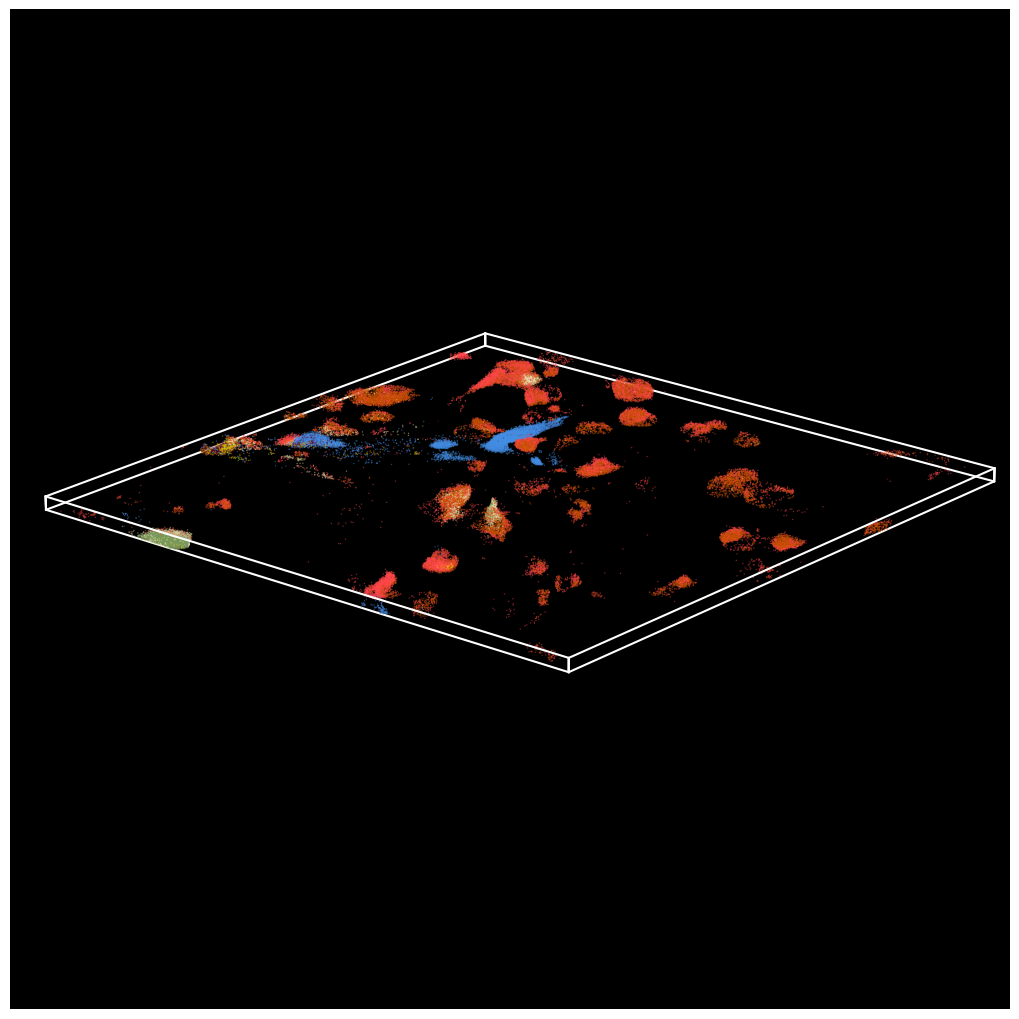

In [7]:
fig = plt.figure(figsize=(10, 10))

print("Feeding the image stack to the network...")

result = model.predict_from_image_file(file_name=input_filename, net=net, dataset=dataset, n_optim_iter=10,
                                       brightness_scaling_method=dataset_scaling, verbose=False)

print("Rendering the tomogram...")

model.render_tomogram(result["false-color stack"], fig, 330.0)